In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Preprocessing

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
import os, shutil, glob
image.LOAD_TRUNCATED_IMAGES = True 
model = VGG16(weights='imagenet', include_top=False)

# Variables
imdir = r'E:\Google 雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\Data'
base_dir = r'E:\Google 雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data\membrane'
targetdir = os.path.join(base_dir,'Clustering')

# Datalist
# datalist = glob.glob(os.path.join(imdir, '*.png'))
# d = []
# for i in datalist:
#     if i[-5] != 't' and i[-5] != 'k':
#         d.append(i)
# datalist = d
datalist = []
masklist = glob.glob(os.path.join(imdir, '*_mask.png'))
resultlist = glob.glob(os.path.join(imdir, '*_result.png'))
for i in masklist:
    datalist.append(i[:-9]+'.png')

# Loop over files and get features
filelist = resultlist
filelist.sort()
featurelist = []
for i, imagepath in enumerate(filelist):
    print("    Status: %s / %s" %(i, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(150, 150))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

Using TensorFlow backend.


# Evaluation

In [3]:
# from sklearn.cluster import KMeans
# # Clustering
# score = []
# for i in range(41):
#     number_clusters = i+1
#     kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))
#     score.append(kmeans.inertia_)
# print(score)
# print(np.argmin(score)+1)

In [4]:
# import matplotlib.pyplot as plt
# k = [i+1 for i in range(41)]
# score = np.array(score)
# d_score = abs(score[2:]-score[1:-1])
# print(np.argmin(d_score))
# plt.figure()
# plt.plot(k, score)
# plt.plot(k[:39],d_score)
# plt.grid('on')
# plt.show()

# Clustering

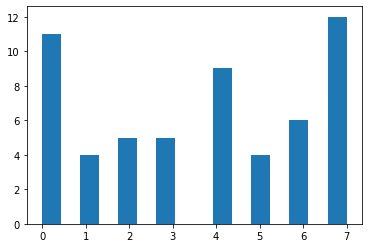

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
number_clusters = 8
kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))
plt.figure()
plt.hist(kmeans.labels_, bins=number_clusters*2)
plt.show()

# Copy images renamed by cluster 
# Check if target dir exists
try:
    shutil.rmtree(targetdir)
except OSError:
    pass
try:
    os.makedirs(targetdir)
except OSError:
    pass
# Copy with cluster name
for i, m in enumerate(kmeans.labels_):
    print("    Copy: %s / %s" %(i, len(kmeans.labels_)), end="\r")
    shutil.copy(filelist[i], os.path.join(targetdir, str(m) + "_" + str(i) + ".png"))

# Splitting dataset

In [6]:
from random import choice
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

try:
    shutil.rmtree(train_dir)
    shutil.rmtree(test_dir)
    shutil.rmtree(os.path.join(base_dir,'test_mask'))
    shutil.rmtree(os.path.join(base_dir,'results'))
except OSError:
    pass
try:
    os.makedirs(train_dir)
    os.makedirs(os.path.join(train_dir,'image'))
    os.makedirs(os.path.join(train_dir,'label'))
    os.makedirs(os.path.join(train_dir,'result'))
    os.makedirs(test_dir)
    os.makedirs(os.path.join(base_dir,'test_mask'))
    os.makedirs(os.path.join(base_dir,'results'))
except OSError:
    pass

labels = kmeans.labels_
testrate = 0.2
# testset_num = round(testrate*len(filelist))
testset_num = 15
count = 0
check = True
while check:
    for i in range(number_clusters):   
        idxs = np.ndarray.tolist(np.where(labels==i)[0])
        if not idxs:
            continue
        idx = choice(idxs)
        shutil.copy(datalist[idx], os.path.join(test_dir, str(count)+".png"))
        shutil.copy(masklist[idx], os.path.join(os.path.join(base_dir,'test_mask'), str(count)+".png"))
        shutil.copy(filelist[idx], os.path.join(os.path.join(base_dir,'results'), str(count)+".png"))
        datalist.pop(idx)
        masklist.pop(idx)
        filelist.pop(idx)
        labels = np.delete(labels,idx)
        count += 1
        if count >= testset_num:
            check = False
            break
for i in range(len(filelist)):
    shutil.copy(datalist[i], os.path.join(os.path.join(train_dir,'image'), str(i)+".png"))
    shutil.copy(masklist[i], os.path.join(os.path.join(train_dir,'label'), str(i)+".png"))
    shutil.copy(filelist[i], os.path.join(os.path.join(train_dir,'result'), str(i)+".png"))